## Introduction 
Stable Diffusion is one of the state of the art text to image generator Model. This notebook will walk you through the whole architecture along with suitable explanations and necessary external links if required to be referred. It will contain the architecture and a demo which will be performed by downloading the weights from Hugging Face. It however won't contain how to train the model as it won't be possible because of the resource constraint.

<h2>Parts of Stable Diffusion Model</h2>
Stable Diffusion Model mainly consist of four parts - <br>
<h4>1. VAE Encoder</h4> 
<h4>2. CLIP Model</h4> 
<h4>3. UNET </h4>
<h4>4. VAE Decoder </h4>



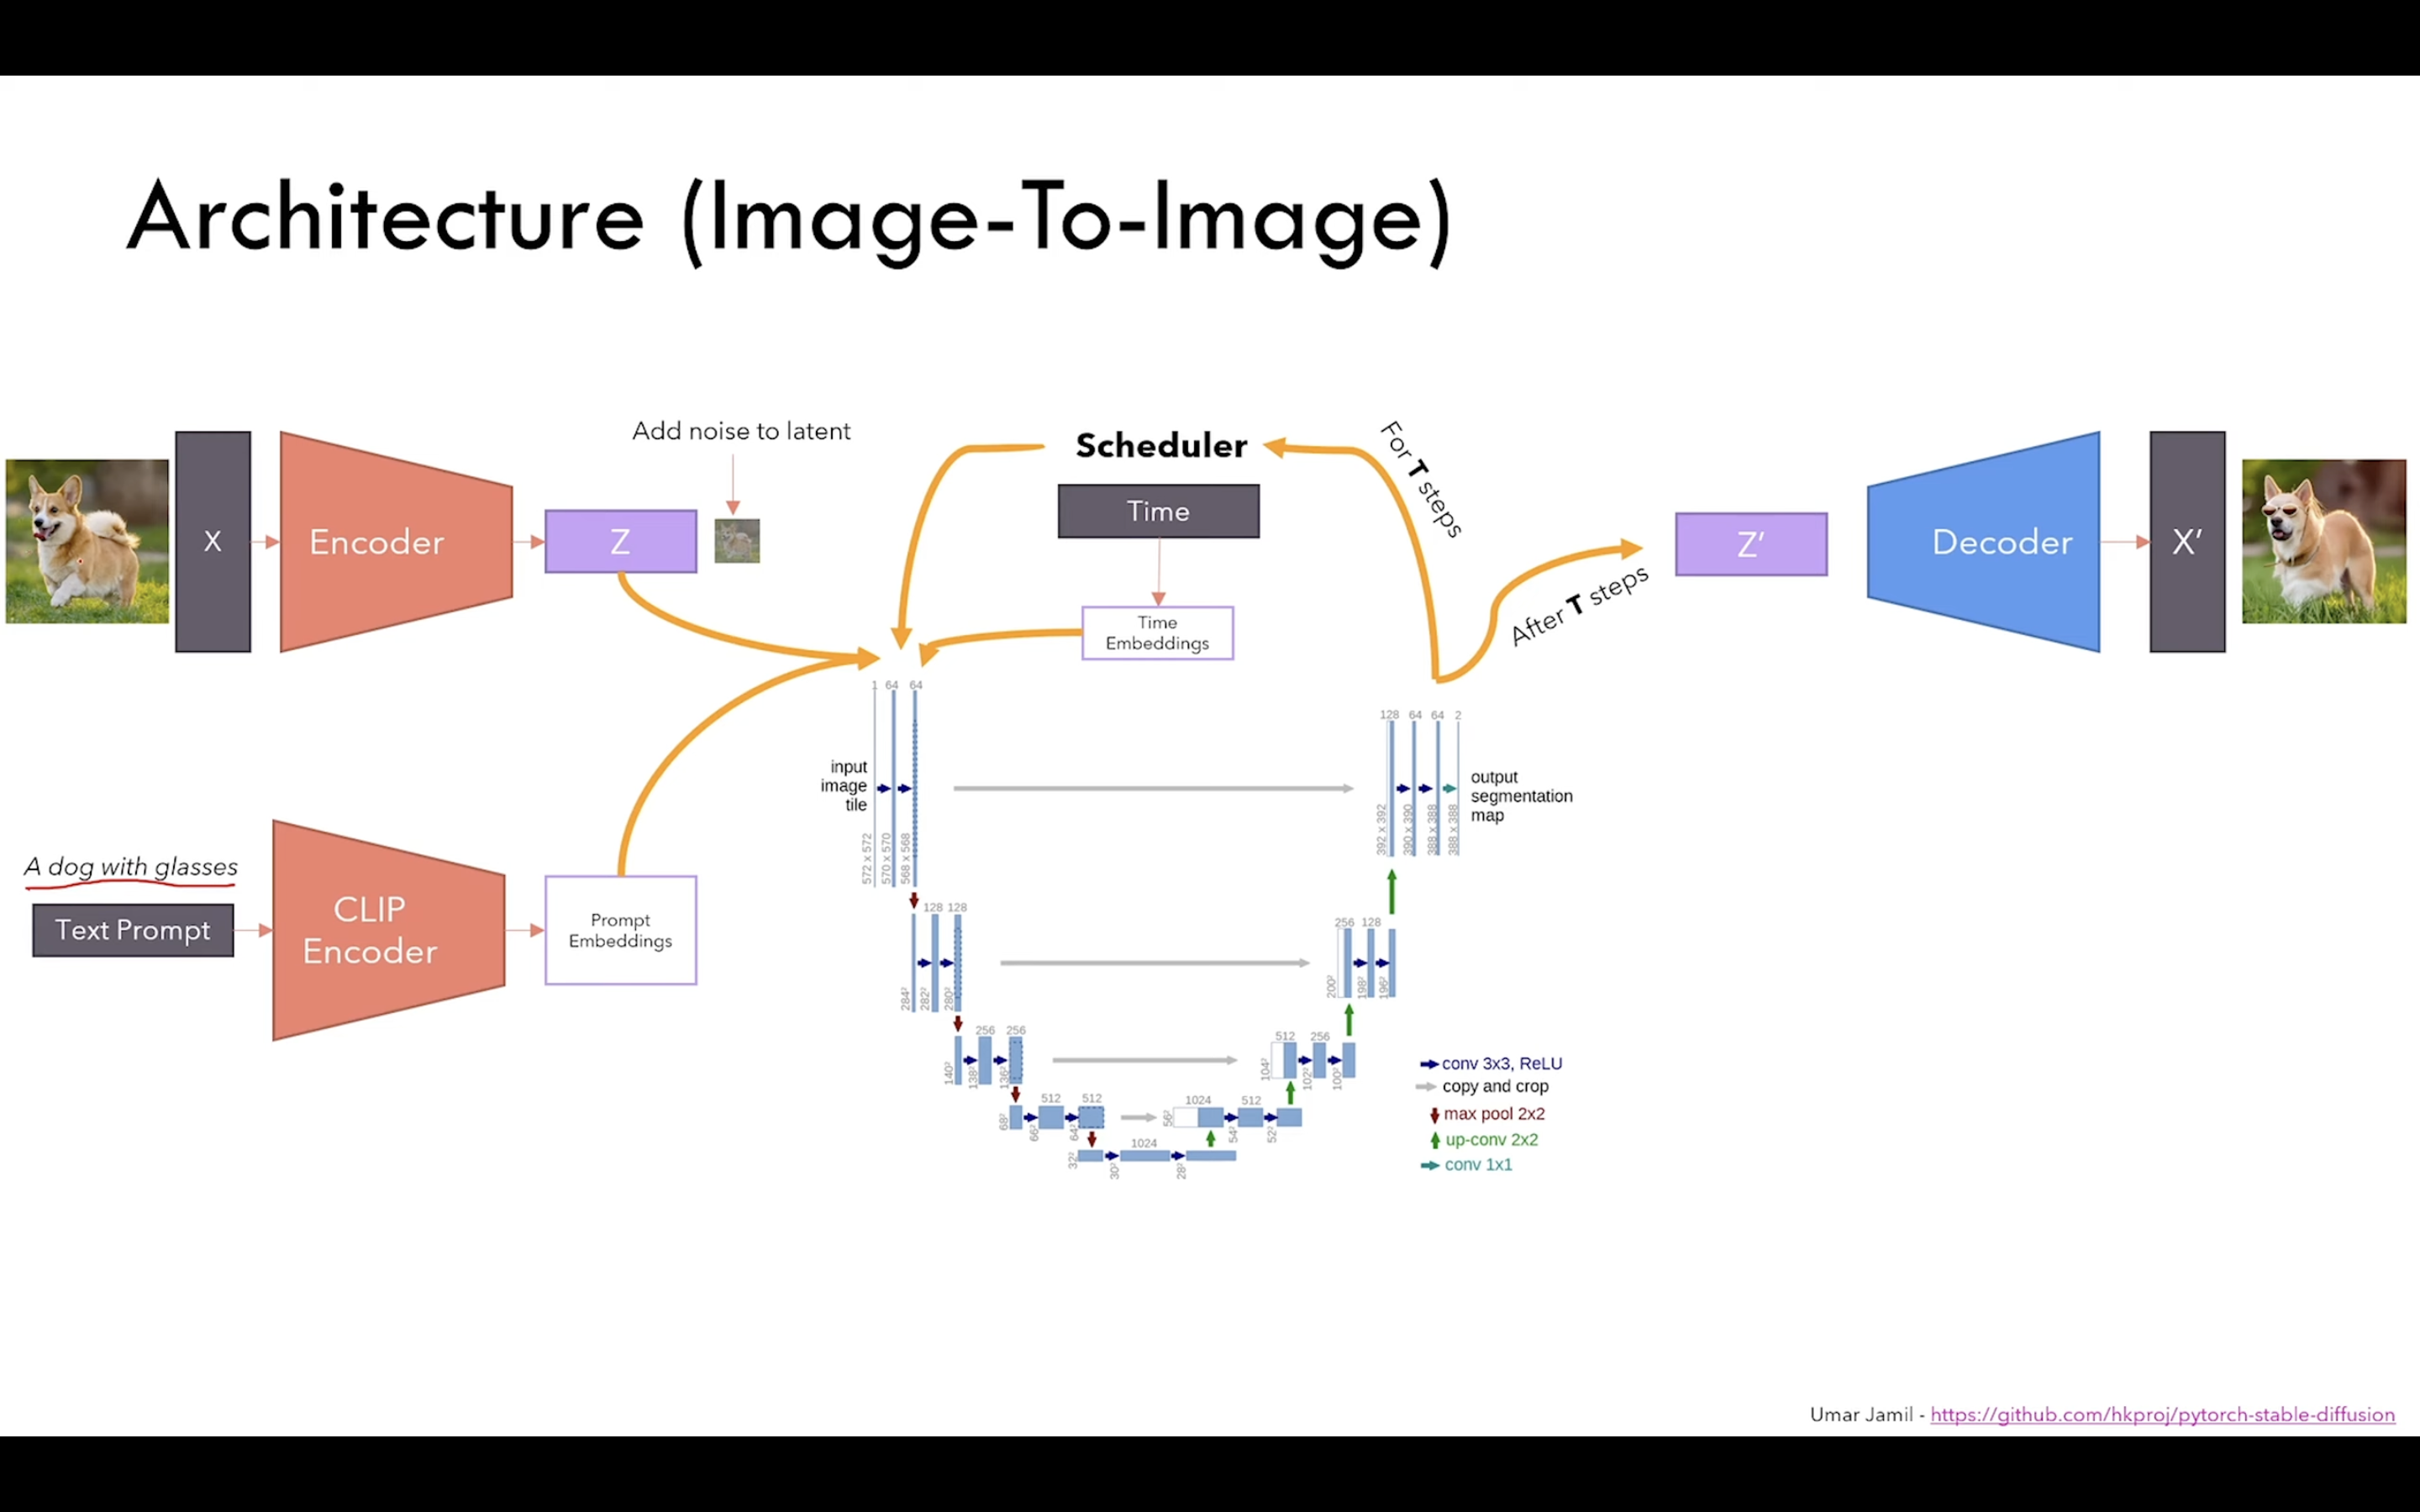

In [1]:
from IPython.display import Image 
Image("/kaggle/input/image-of-the-model/Screenshot 2024-01-06 at 1.06.12 AM.png")

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import math
import numpy as np



In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Attention

In [4]:

class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias = True, out_proj_bias = True):
        super().__init__()
        self.in_proj = nn.Linear(in_features = d_embed, out_features = d_embed * 3, bias = in_proj_bias)
        self.out_proj = nn.Linear(in_features = d_embed, out_features = d_embed, bias = out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask = False):
        input_shape = x.shape
        batch, seq_len, d_embed = input_shape

        q, k, v = self.in_proj(x).chunk(3, dim = -1)
        interim_shape = (batch, seq_len, self.n_heads, self.d_head)

        q = q.reshape(interim_shape).transpose(1, 2)
        k = k.reshape(interim_shape).transpose(1, 2)
        v = v.reshape(interim_shape).transpose(1, 2)

        weights = q @ k.transpose(-1, -2)

        if causal_mask:
            mask = torch.ones_like(weights, dtype = torch.bool).triu(1)
            weights.masked_fill(mask, -torch.inf)
        weights /= math.sqrt(self.d_head)
        weights = F.softmax(weights, dim = -1)

        outputs = weights @ v
        outputs = outputs.transpose(1, 2)
        outputs = outputs.reshape(input_shape)
        outputs = self.out_proj(outputs)
        return outputs


class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias = True, out_proj_bias= True):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias = in_proj_bias)
        self.k_proj = nn.Linear(d_cross, d_embed, bias = in_proj_bias)
        self.v_proj = nn.Linear(d_cross, d_embed, bias = in_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
        self.out_proj = nn.Linear(d_embed, d_embed, bias = out_proj_bias)

    def forward(self, x, context):
        input_shape = x.shape
        batch, seq_len, d_embed = input_shape 

        q = self.q_proj(x)
        k = self.k_proj(context)
        v = self.v_proj(context)

        interim_shape = (batch, -1, self.n_heads, self.d_head)
        q = q.reshape(interim_shape).transpose(1, 2)
        k = k.reshape(interim_shape).transpose(1, 2)
        v = v.reshape(interim_shape).transpose(1, 2)

        weights = q @ k.transpose(-1, -2)
        weights/= math.sqrt(self.d_head)
        outputs = weights @ v

        outputs = outputs.transpose(1, 2)
        outputs = outputs.reshape(input_shape)
        outputs = self.out_proj(outputs)
        return outputs



In [5]:
# x = torch.randn(1, 64 * 64, 640)
# context = torch.randn(1, 77, 768)
# self_attention = SelfAttention(10, 640)
# out = self_attention(x)
# out.shape

# VAE Helper Classes

In [6]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x):
        residue = x
        x = self.groupnorm(x)
        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        x = x.transpose(-1, -2)
        x = self.attention(x)
        x = x.view((n, c, h, w))
        return x + residue

class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size = 3,padding = 1)

    def forward(self, x):
        residue = x
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)
        print("successfully passed")
        return x + self.residual_layer(residue)


# VAE Encoder

In [7]:
class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(in_channels = 3,out_channels = 128, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 2, padding = 0),
            VAE_ResidualBlock(128, 256),
            VAE_ResidualBlock(256, 256),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 2, padding = 0),
            VAE_ResidualBlock(256, 512),
            VAE_ResidualBlock(512, 512),
            nn.Conv2d(in_channels = 512, out_channels =512, kernel_size = 3, stride = 2, padding =0),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Conv2d(in_channels = 512, out_channels = 8, kernel_size = 3, padding =1), 
            nn.Conv2d(in_channels =8, out_channels = 8, kernel_size = 1, padding = 0)
        )


    def forward(self, x, noise):
        for module in self:
            if getattr(module, "stride", None) == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))

            x = module(x)

        mean, log_variance = x.chunk(2, dim = 1)
        log_variance = torch.clamp(log_variance, min = -30, max = 20)
        variance = log_variance.exp()
        std_dev = variance.sqrt()
        x = mean + noise * std_dev
        return x


In [8]:
# vae_encoder = VAE_Encoder()
# input = torch.randn(1, 3, 512, 512)
# noise = torch.randn(1, 4, 64, 64)
# encoder_outputs = vae_encoder(input, noise)
# encoder_outputs.shape

# VAE Decoder

In [9]:
class VAE_Decoder(nn.Sequential):
      def __init__(self):
        super().__init__(
            nn.Conv2d(4, 4, kernel_size = 1, padding = 0),
            nn.Conv2d(4, 512, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(512, 512, kernel_size = 3, padding =1),
            VAE_ResidualBlock(512, 256),
            VAE_ResidualBlock(256, 256),
            VAE_ResidualBlock(256, 256),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(256, 128),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size = 3, padding = 1)

        )

        def forward(self, x):
            x /= 0.18125
            for module in self:
                x = module(x)

            return x

In [10]:
# vae_decoder = VAE_Decoder()
# decoder_output = vae_decoder(encoder_outputs)
# decoder_output.shape

# CLIP

In [11]:
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab, n_embd, n_tokens):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, n_embd)
        self.positional_embedding = nn.Parameter(torch.randn(n_tokens, n_embd))

    def forward(self, x):
        x = self.embedding(x)
        x+= self.positional_embedding
        return x


class CLIPLayer(nn.Module):
    def __init__(self, n_head, n_embd):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(n_embd)
        self.attention = SelfAttention(n_head, n_embd)

        self.layernorm_2 = nn.LayerNorm(n_embd)

        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        residue = x
        x = self.layernorm_1(x)
        x = self.attention(x, causal_mask = True)
        x+= residue

        residue = x
        x = self.layernorm_2(x)
        x = self.linear_1(x)
        x = x * torch.sigmoid(1.702 * x)
        x = self.linear_2(x)

        x+= residue
        return x

class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49708, 768, 77)
        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])
        self.layernorm = nn.LayerNorm(768)


    def forward(self, tokens):
        tokens = tokens.type(torch.long)
        state = self.embedding(tokens)

        for layer in self.layers:
            state = layer(state)

        output = self.layernorm(state)

        return output


# Diffusion Helper Classes

In [12]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, time):
        time = self.linear_1(time)
        time = F.silu(time)
        time = self.linear_2(time)
        return time 

class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time = 1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding =1)
        self.linear_time = nn.Linear(n_time, out_channels)
        self.groupnorm_merged =  nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)

    def forward(self, feature, time):
        residue = feature

        feature = self.groupnorm_feature(feature)
        feature = F.silu(feature)
        feature = self.conv_feature(feature)

        time = F.silu(time)
        time = self.linear_time(time)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)
        merged = self.groupnorm_merged(merged)
        merged = self.conv_merged(merged)

        return merged + self.residual_layer(residue)


class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_heads, n_embed, d_context = 768):
        super().__init__()
        channels = n_heads * n_embed
        self.groupnorm = nn.GroupNorm(32, channels)
        self.conv_in = nn.Conv2d(channels, channels, kernel_size = 1, padding = 0)
    
        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention = SelfAttention(n_heads, channels)

        self.layernorm_2 = nn.LayerNorm(channels)
        self.cross_attention = CrossAttention(n_heads, channels, d_context, in_proj_bias = False)

        self.layernorm_3= nn.LayerNorm(channels)
        self.linear_geglu1 = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu2 = nn.Linear(channels * 4, channels)

        self.conv_out = nn.Conv2d(channels, channels, kernel_size = 1, padding = 0)

    def forward(self, x, context):
        residue_long = x

        x = self.groupnorm(x)
        x = self.conv_in(x)

        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        x = x.transpose(-1, -2)


        residue_short = x
        x = self.layernorm_1(x)
        x = self.attention(x)
        x+= residue_short 

        residue_short = x
        x = self.layernorm_2(x)
        x = self.cross_attention(x, context)
        x+= residue_short

        residue_short = x
        x = self.layernorm_3(x)
        x = self.linear_geglu1(x)
        x, gate = x.chunk(2, dim = -1)
        x = x * F.gelu(gate)
        x = self.linear_geglu2(x)

        x = x.transpose(-1, -2)
        x = x.view((n, c,  h, w))

        return self.conv_out(x) + residue_long



class UpSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)
    

    def forward(self, x):
        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        return self.conv(x)



class SwitchSequential(nn.Sequential):
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            elif isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            else:
                x = layer(x)

        return x


# Diffusion UNET

In [13]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, 320, kernel_size = 3, padding = 1)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)), 
            
            SwitchSequential(nn.Conv2d(320, 320, kernel_size = 3, stride = 2, padding = 1)), 
            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)), 
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)), 
            
            SwitchSequential(nn.Conv2d(640, 640, kernel_size = 3, stride = 2, padding = 1)), 
            SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)), 
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)), 
            
            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size = 3, stride = 2, padding = 1)), 
            SwitchSequential(UNET_ResidualBlock(1280, 1280)), 
            SwitchSequential(UNET_ResidualBlock(1280, 1280))
        ])
        
        self.bottleneck = SwitchSequential(
            UNET_ResidualBlock(1280, 1280), 
            UNET_AttentionBlock(8, 160), 
            UNET_ResidualBlock(1280, 1280)
            )
        
        self.decoder = nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(2560, 1280)), 
            SwitchSequential(UNET_ResidualBlock(2560, 1280)), 
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UpSample(1280)), 
            
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)), 
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)), 
            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), UpSample(1280)), 
            
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)), 
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)), 
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), UpSample(640)), 
            
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)), 
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)), 
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40))
        ])
        
    def forward(self, x, context, time):
        skip_connections = []
        for layer in self.encoder:
            x = layer(x, context, time)
            skip_connections.append(x)
            
        x = self.bottleneck(x, context, time)
        for layer in self.decoder:
            x = torch.cat([x, skip_connections.pop()], dim = 1)
            x = layer(x, context, time)
            
        return x
    
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        
    def forward(self, x):
        x = self.groupnorm(x)
        x = F.silu(x)
        x = self.conv(x)
        return x 
    
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)
        
    def forward(self, latent, context, time):
        time= self.time_embedding(time)
        output = self.unet(latent, context, time)
        output = self.final(output)
        return output

In [14]:
x = torch.randn(1, 4, 64, 64)
context = torch.randn(1, 77, 768)
time = torch.randn(1, 320)

diffusion = Diffusion()
out = diffusion(x, context, time)
out.shape

torch.Size([1, 4, 64, 64])

# DDPM Sampler

In [15]:
class DDPMSampler:
    def __init__(self, generator, num_training_steps = 1000, beta_start = 0.00085, beta_end = 0.0120):
        self.betas = torch.linspace(beta_start ** 0.5, 
                                    beta_end ** 0.5, 
                                    num_training_steps, 
                                    dtype = torch.float )
        self.alphas = 1.0 - self.betas 
        self.alpha_cumprod = torch.cumprod(self.alphas, 0)
        self.one = torch.tensor(1.0)
        
        self.generator = generator
        self.num_training_steps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy().astype(np.int64))
        
        
    def set_inference_timesteps(self, num_inference_steps):
        self.num_inference_steps = num_inference_steps 
        step_ratio = self.training_steps // self.num_inference_steps 
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)
        
    def _get_previous_timestep(self, timestep):
        prev_t = timestep - self.num_training_steps // self.num_inference_steps
        return prev_t 
        
    def add_noise(self, original_samples, timesteps):
        self.alpha_cumprod = self.alpha_cumprod.to(device = orignal_samples.device, dtype = original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)
        
        sqrt_alpha_cumprod = self.alpah_cumprod ** 0.5
        sqrt_alpha_cumprod = sqrt_alpha_cumprod.flatten()
        while len(sqrt_alpha_cumprod.shape) < len(original_samples.shape):
            sqrt_alpha_cumprod = sqrt_alpha_cumprod.unsqueeze(-1)
            
        sqrt_one_minus_alpha_cumprod = (1 - self.alpha_cumprod) ** 0.5 
        sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.flatten()
        while len(sqrt_one_minus_alpha_cumprod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.unsqueeze(-1)
        
        noise = torch.randn(original_samples.shape, 
                            generator = self.generator, 
                            device = original_samples.device, 
                            dtype = original_samples.dtype)
        noised_images = sqrt_alpha_cumprod * orignal_samples + sqrt_one_minus_alpha_cumprod * noise
        return noised_images
    
    